In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

# K均值聚类
K均值聚类法是一种“自上而下的方法”，由于其全局最小解的算法过于复杂，故使用如下的迭代算法：
1. 随机选择每个聚类的中心位置（初始化）。
2. 循环执行以下两步，直至收敛：
   >分配过程，将每个观测值重新分配到离其最近的聚类；
   
   >更新过程，更新分配后的每个聚类的质心centroid。

为充分理解K均值聚类的理论含义，本案例使用sklearn自带数据集wine以演示K-means的操作流程。wine收录了3种不同类型酒的13个化学成分数据，数据来源于意大利某酿酒地区。

In [2]:
data=load_wine()
dir(data)#使用dir函数查看sklearn数据集的属性。

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [3]:
X=pd.DataFrame(data.data,columns=[data.feature_names])
y=data.target

wine数据集共有178条样本数据，13个特征变量。

In [4]:
X.shape

(178, 13)

KMeans类主要参数介绍：
1. n_clusters，选择聚类个数K，默认为8。
2. init，选择初始化的方法，有‘k-means++’和‘random’两种选项，前者表示以一种优化的方式选择每个聚类的中心位置，从而加快收敛的速度，后者表示随机进行初始化，默认为random。
3. n_init，选择初始化的次数，使局部最小值尽量接近全局最小值，默认次数为10。
4. algorithm,有“auto”, “full”, “elkan”三种选项，full表示使用最大期望算法EM；对于界限较为清晰的数据，elkan通过使用三角不等式以提高效率；auto表示选择elkan，默认选择auto。

KMeans类主要属性介绍：
1. cluster_centers_属性，返回每个聚类的质心坐标。
2. labels_属性，返回每个样本的聚类归属。
3. inertia_属性，返回SSE误差平方和，即$$SSE=\sum_{k=1}^{K}\sum_{i\in C_k}||x_i-c_k||^2$$
4. n_iter_表示迭代次数。
5. n_features_in_表示特征变量个数

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)#划分训练集和测试集

def optimize_k(X):#最优化K
    global K#设定全局变量，以便下文使用
    K=range(1,16)

    sse=[]#误差平方和
    mean_distortions=[]#计算各个点分别到 k 个质心的距离，取其最小值作为其到所属质心的距离，并计算这些点到各自所属质心距离的平均距离
    aic=[]#AIC信息准则
    bic=[]#BIC信息准则

    for k in K:
        model=KMeans(n_clusters=k,n_init=30,random_state=1).fit(X)#生成实例model，并使用fit方法

        sse.append(model.inertia_)
        
        distortion=np.sum(np.min(cdist(X,model.cluster_centers_,'euclidean'),axis=1))#计算各点分别到 k 个质心的距离，取其最小值作为其到所属质心的距离
        mean_distortions.append(distortion/X.shape[0])#计算各点到各自所属质心距离的平均距离

        aic.append(model.inertia_+2*X.shape[1]*k)
        bic.append(model.inertia_+2*np.log(X.shape[0])*k)
    return sse,mean_distortions,aic,bic

def plot_k(metrics,ylabel,vertical_line=False):
    plt.plot(K,metrics,'ko-')

    if vertical_line==True:
        plt.axvline(np.argmin(metrics)+1,linestyle='--',color='b')#画垂直于x轴的直线，寻找使aic或bic最小的k
        
    plt.xlabel('The Number of K')
    plt.ylabel(ylabel)

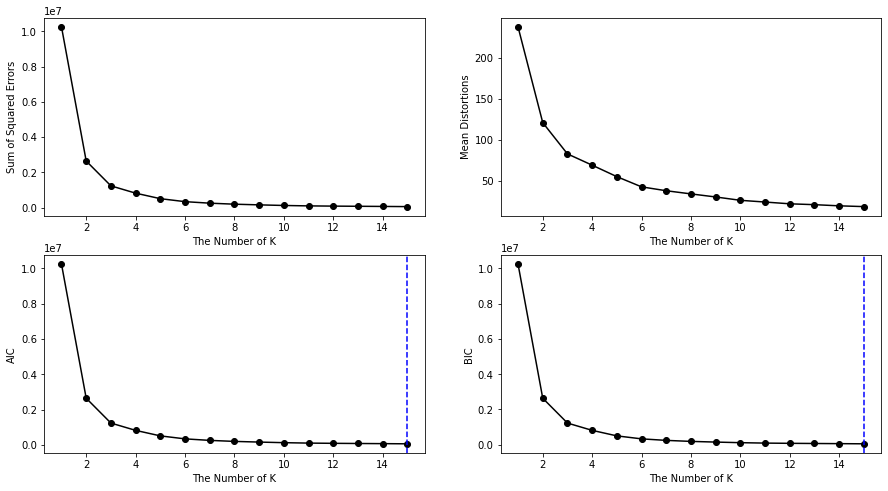

In [6]:
sse,mean_distortions,aic,bic=optimize_k(X_train)

plt.figure(figsize=(15,8))

plt.subplot(221)
plot_k(sse,'Sum of Squared Errors')

plt.subplot(222)
plot_k(mean_distortions,'Mean Distortions')

plt.subplot(223)
plot_k(aic,'AIC',vertical_line=True)

plt.subplot(224)
plot_k(bic,'BIC',vertical_line=True)

由上图可得，SSE误差平方和较大且aic、bic信息准则的惩罚项几乎没有影响，推测可能是个别变量的数值较大，从而对样本与质心的距离产生了较大影响，故应将变量归一化。

In [7]:
scale=MinMaxScaler()#生成归一化类的实例scale
scale.fit(X_train)
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)


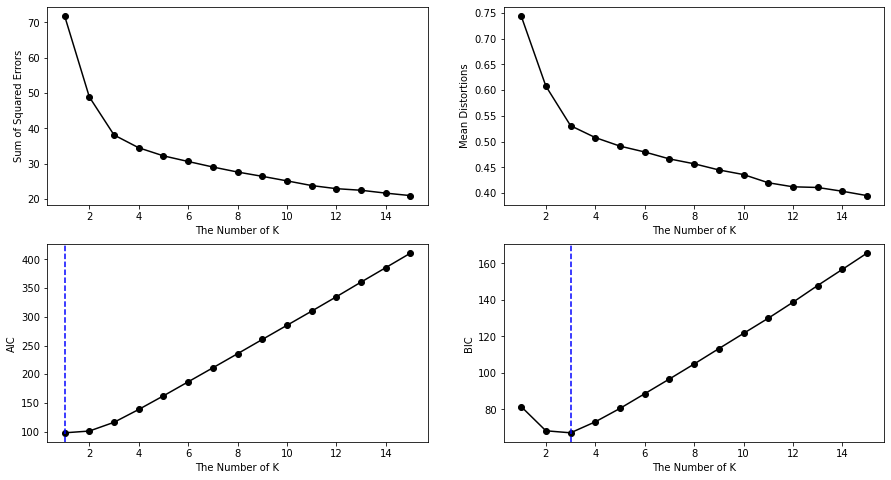

In [8]:
sse,mean_distortions,aic,bic=optimize_k(X_train)

plt.figure(figsize=(15,8))

plt.subplot(221)
plot_k(sse,'Sum of Squared Errors')

plt.subplot(222)
plot_k(mean_distortions,'Mean Distortions')

plt.subplot(223)
plot_k(aic,'AIC',vertical_line=True)

plt.subplot(224)
plot_k(bic,'BIC',vertical_line=True)


将特征变量归一化后，个别特征变量对SSE产生的较大影响被消除，以SSE和Mean Distortion作为选择指标，通过手肘法确定的聚类个数K为3，aic信息准则确定的K为2，bic确定的K为3。

In [9]:
pd.DataFrame(y,columns=['y'])['y'].value_counts()

1    71
0    59
2    48
Name: y, dtype: int64

由响应变量y的分布状况可知，聚类个数被设置为3类是正确的。下面考察聚类的准确性。

In [10]:
model=KMeans(n_clusters=3,n_init=30,random_state=1).fit(X_train)
model.labels_

array([2, 0, 0, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 2,
       0, 1, 0, 1, 1, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2,
       2, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 2, 2, 0, 1, 2, 2, 1, 1, 2,
       2, 2, 1, 1, 2, 0, 2, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, 1, 1, 0,
       2, 2, 1, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 0], dtype=int32)

In [11]:
y_train

array([1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 0, 2, 2, 2, 2, 1, 1,
       0, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 1, 0, 1, 1, 0, 2, 1, 1, 2, 2, 1,
       1, 1, 2, 2, 1, 0, 1, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 2, 0,
       1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2,
       2, 1, 0, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 0])

与y值作比较，大致可得K均值聚类所预测的类别2对应1，0对应0，1对2。之所以出现这种情形，是因为K-means预测样本的聚类时，是指定一个数字进行标注的，该数字并不一定与y相等，故需转换。

In [12]:
pred=pd.DataFrame(model.predict(X_test),columns=['Predictions'])
pred=pred['Predictions'].map({2:1,0:0,1:2})#使用map方法转换数据，map方法的作用对象是series
matrix=confusion_matrix(y_test,pred)#严格来说，由于K均值聚类属于无监督学习，故不存在混淆矩阵，但在实际应用过程中，仍可以使用混淆矩阵查看聚类的准确度。

<AxesSubplot:>

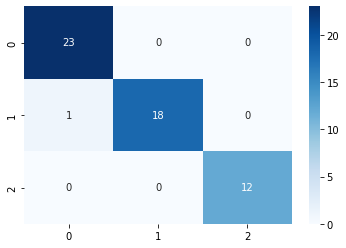

In [13]:
sns.heatmap(matrix,annot=True,cmap='Blues')#生成混淆矩阵的热图

由混淆矩阵可得，54个测试集样本中，只有一个样本不在主对角线上，即只有一个样本被分类错误。

In [14]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.95      0.97        19
           2       1.00      1.00      1.00        12

    accuracy                           0.98        54
   macro avg       0.99      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



K均值聚类可以在测试集中获得0.98的f1得分。
<br/><br/>
<br/><br/>
<br/><br/>
# 自组织神经网络 SOM


In [15]:
from sklearn.datasets import load_breast_cancer
from minisom import MiniSom
import math

In [16]:
data=load_breast_cancer()
dir(data)

['DESCR',
 'data',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

breast cancer数据集共包含569个样本，30个特征变量和1个分类变量，即是否患乳腺癌。

In [17]:
X=pd.DataFrame(data.data,columns=[data.feature_names])
y=data.target
X.shape

(569, 30)

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)#划分训练集和测试集

scale=MinMaxScaler().fit(X_train)#归一化处理
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)

MiniSom类主要包含如下参数：
1. size，输出层（竞争层）的宽。
2. size，输出层（竞争层）的高。两个size参数相乘可得到竞争层中神经元的个数，该个数可由经验公式size $=5\sqrt{N}$确定。
3. M，特征向量的维度。
4. sigma，确定优胜邻域的范围。
5. learning_rate，学习率，默认值为0.5。
6. neighborhood_function，用于调整优胜邻域内的神经元权重，包括'gaussian'、'mexican_hat'、'bubble'。

MiniSom类主要包含如下方法：
1. pca_weights_init(X)，X为要输入的数据，PCA指linear initialization，让网络向输入数据能力最大的方向延伸。
2. random_weights_init(X)，优点是在初始时刻，网络节点就与输入数据的拓扑结构很相似。
3. train_batch(X,max_iter)，以序列的方式从X中依次抽取一个样本，抽取完最后一个样本则跳转到第一个样本，循环次数为max_iter。
4. train_random(X,max_iter)，作用于train_batch相似，只是改为随机抽取样本。
5. distance_map()，返回竞争层中每个神经元与邻近神经元的欧几里得距离。
6. labels_map(X,labels)，利用样本的标签信息，标注神经网络。

In [19]:
size=math.ceil((5*X_train.shape[0]**0.5)**0.5)#因为是二维平面，故再次开方，且向上取整。
M=X_train.shape[1]#特征向量维数
model=MiniSom(size,size,M,sigma=3,learning_rate=0.5,neighborhood_function='bubble',random_seed=1)#实例化

In [20]:
model.pca_weights_init(X_train)
model.train_batch(X_train,200)

根据权重矩阵，可以计算神经元与其邻居神经元的距离，所得距离矩阵即为U-matirx酉矩阵。颜色越深，表明位于此处的神经元与其邻近神经元的距离越远，即聚类。由上图可得，样本可能在左下角、右下角和中部靠左上方位置处被分类。

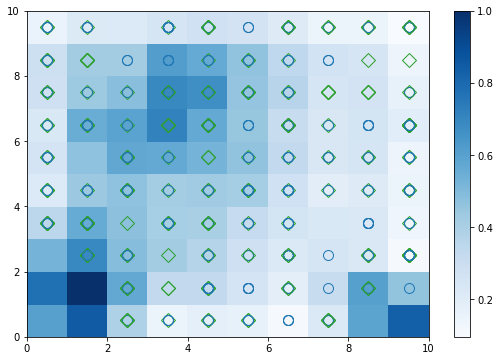

In [21]:
markers = ['o', 's', 'D']#标注样本
colors = ['C0', 'C1', 'C2']#标注样本

plt.figure(figsize=(9,6))
for index,x in enumerate(X_train):
    coordinate=model.winner(x)#得到获胜神经元的坐标
    plt.plot(coordinate[0]+0.5,coordinate[1]+0.5,markers[y[index]-1],markerfacecolor='None',markeredgecolor=colors[y[index]-1], markersize=10)

plt.pcolor(model.distance_map().T,cmap='Blues')
plt.colorbar()

由上图可得，样本可能在左下角、右下角和中部靠左上方位置处被分类。

In [22]:
def classify(X):#该函数的作用是识别传递的数据，并返回聚类结果。
    win_map = model.labels_map(X_train, y_train)
    default_class=np.sum(list(win_map.values())).most_common()[0][0]#若输入某样本后没有激发神经元，即没有聚类结果，则指定最常见的聚类结果。
    result=[]
    for i in X:
        win_coordinate=model.winner(i)
        if win_coordinate in win_map:
            result.append(win_map[win_coordinate].most_common()[0][0])
        else:
            result.append(default_class)
    return result

<AxesSubplot:>

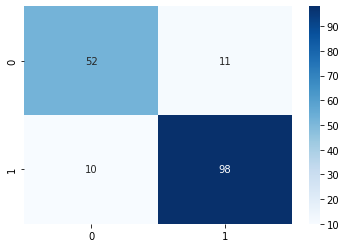

In [23]:
pred=classify(X_test)
sns.heatmap(confusion_matrix(y_test,pred),annot=True,cmap='Blues')

在测试集的171个数据中，共有6+10个样本被预测错误。

In [24]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83        63
           1       0.90      0.91      0.90       108

    accuracy                           0.88       171
   macro avg       0.87      0.87      0.87       171
weighted avg       0.88      0.88      0.88       171



自组织神经网络可以在测试集中获得0.91的f1得分。